# 1. Introduction

This project is the second assignment in the course - Machine Learning with Python-From Linear Models to Deep Learning by MITx. This course is part of the MITx MicroMasters Program in Statistics and Data Science.
For further details, please visit (https://www.edx.org/course/machine-learning-with-python-from-linear-models-to).

The goal of this project is to implement various ML tools, including logistic regression, non-linear features, regularization, and kernel tricks, to solve the famous digit recognition problem - MNIST.

The MNIST database contains binary images of handwritten digits commonly used to train image processing systems. The digits were collected from among Census Bureau employees and high school students. The database contains 60,000 training digits and 10,000 testing digits, all of which have been size-normalized and centered in a fixed-size image of 28 × 28 pixels. In this project, we will classify these images into the correct digit using the aforementioned methods.

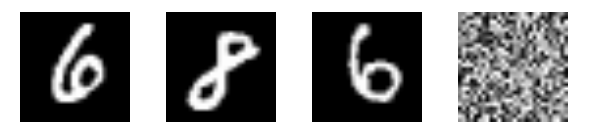

Below are the properties of the data:

**train_x :** A matrix of the training data. Each row of train_x contains the features of one image, which are simply the raw pixel values flattened out into a vector of length $784=28^{2}$ . The pixel values are float values between 0 and 1 (0 stands for black, 1 for white, and various shades of gray in-between).

**train_y :** The labels for each training datapoint, also known as the digit shown in the corresponding image (a number between 0-9).

**test_x :** A matrix of the test data, formatted like train_x.

**test_y :** The labels for the test data, which should only be used to evaluate the accuracy of different classifiers in your report.

Let's plot some examples!

In [1]:
import pickle, gzip, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import math

def plot_images(X):
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()

def read_pickle_data(file_name):
    f = gzip.open(file_name, 'rb')
    data = pickle.load(f, encoding='latin1')
    f.close()
    return data

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

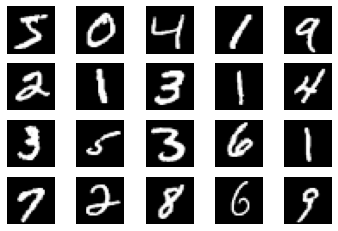

In [2]:
# Load MNIST data:
train_x, train_y, test_x, test_y = get_MNIST_data()

# Plot the first 20 images of the training set.
plot_images(train_x[0:20, :])

# 2. Support Vector Machine

We will begin with a binary classification and build an one vs. rest model for every digit. For example, classifying the digits into two classes: `0` and `not 0`.

### One vs. Rest SVM

- Use the sklearn package and build the SVM model
- Use random_state = 0, C=0.1 and default values for other parameters.

In [3]:
from sklearn.svm import LinearSVC

In [4]:
def one_vs_rest_svm(train_x, train_y, test_x, c=0.1):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """    
    clf = LinearSVC(C=c, random_state=0)
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)
    return pred_test_y

### Binary classification error

Write a function run_svm_one_vs_rest_on_MNIST that changes the labels of digits 1-9 to 1 and keeps the label 0 for digit 0. 

In [5]:
# Testing Function

def compute_test_error_svm(test_y, pred_test_y):
    return 1 - np.mean(pred_test_y == test_y)

def run_svm_one_vs_rest_on_MNIST(c=0.1):
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x, c)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

In [6]:
print('SVM one vs. rest test_error:', np.float32(run_svm_one_vs_rest_on_MNIST()))

SVM one vs. rest test_error: 0.0075


### Implement C-SVM

Play with the C parameter of SVM, and see what's the changes?

In [7]:
print('SVM one vs. rest test_error:', np.float32(run_svm_one_vs_rest_on_MNIST(c=0.0001)))
print('SVM one vs. rest test_error:', np.float32(run_svm_one_vs_rest_on_MNIST(c=1)))

SVM one vs. rest test_error: 0.0101
SVM one vs. rest test_error: 0.0085


/Users/BillyLam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Larger C gives smaller tolerance of violation because of a smaller margin separating plane.

### Multiclass SVM

In fact, `sklearn` already implements a multiclass SVM with a one-vs-rest strategy. Use `LinearSVC` to build a multiclass SVM model.

In [8]:
def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = LinearSVC(multi_class='ovr', C=0.1, random_state=0)
    clf.fit(train_x,train_y)
    pred_test_y = clf.predict(test_x)
    return pred_test_y

### Multiclass SVM error

In [9]:
def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

In [10]:
print('Multiclass SVM test_error: %.4f' % run_multiclass_svm_on_MNIST())

Multiclass SVM test_error: 0.0819


Binary Classification semms to work better than Multiclass SVM for MINST dataset. Let's explore another model and see if it's the best.

# 3. Multinomial (Softmax) Regression and Gradient Descent

Instead of building ten models, we can expand a single logistic regression model into a multinomial regression and solve it with similar gradient descent algorithm. In order for the regression to work, we will implement three methods in the followings.

### Computing Probabilities for Softmax

Write a function `compute_probabilities` that computes, for each data point $x^{i}$, the probability that $x^{i}$ is labeled as $j$ for $j$ = 0,1,…,𝑘−1 .

The softmax function $h$ for a particular vector $x$ requires computing below, where $r>0$ is the **temperature parameter**.

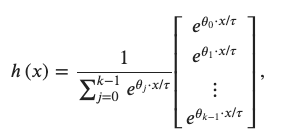

When computing the output probabilities (they should always be in the range [0,1]), the terms $e^{\theta_{j}⋅x/r}$ may be very large or very small, due to the use of the exponential function.

This can cause numerical or overflow errors. To deal with this, we can simply subtract some fixed amount $c$ from each exponent to keep the resulting number from getting too large. Since subtracting some fixed amount $c$ from each exponent will not change the final probabilities.

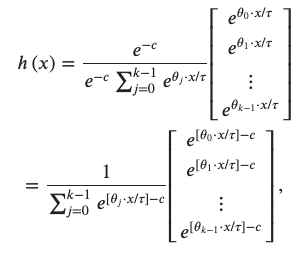

A suitable choice for this fixed amount is $c=max_{j}\theta_{j}⋅x/r$.

In [11]:
def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].

    Args:
        X - a NumPy matrix of n data points, each with d - 1 features

    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

In [12]:
def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    aux = np.dot(theta, X.T) / temp_parameter
    c = np.max(aux, axis=0)
    aux = aux - c
    
    numerator = np.exp(aux)
    denumerator = np.sum(numerator, axis=0)
    H = numerator / denumerator
    return H

### Cost Function

Write a function `compute_cost_function` that computes the total cost over every data point.

The cost function $J(\theta)$ is given by: (Use natural log)
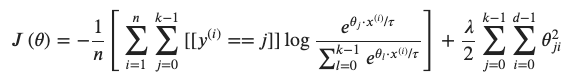

In [13]:
import scipy.sparse as sparse

def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    k = theta.shape[0]
    n = X.shape[0]
    
    # Loss term
    H = np.log( compute_probabilities(X, theta, temp_parameter) )
    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape = (k,n)).toarray()
    loss_term = (-1/n) * np.sum(H[M == 1])
                
    # Regularization term
    reg_term = (lambda_factor/2) * (np.linalg.norm(theta)**2)
    
    return loss_term + reg_term

### Gradient Descent

Now, in order to run the gradient descent algorithm to minimize the cost function, we need to take the derivative of $J(\theta)$ with respect to a particular $\theta_{m}$ . Notice that within $J(\theta)$, we have:
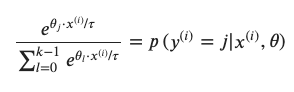

so we first compute:
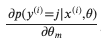

when $m = j$:
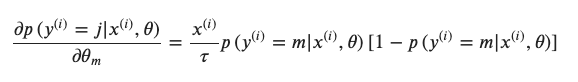

when $m \neq j$:
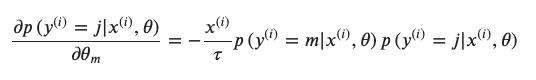


Then compute:
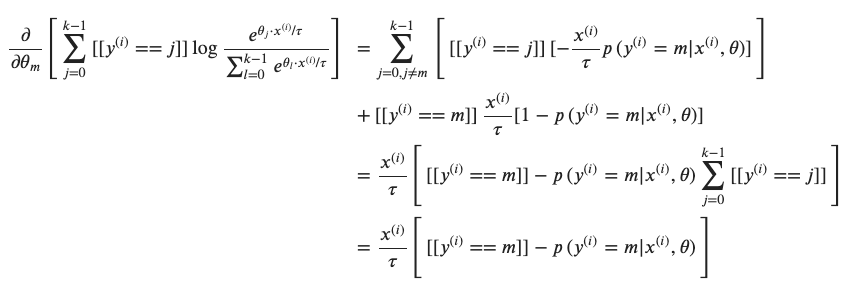

Plug this into the derivatite of $J(\theta)$, we have:
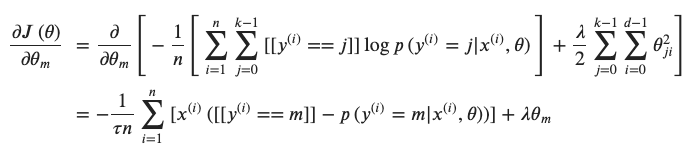


Write a function `run_gradient_descent_iteration` that runs one step of the gradient descent algorithm.

In [14]:
def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    k = theta.shape[0]
    n = X.shape[0]
    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape = (k,n)).toarray()
    
    Prob_matrix = compute_probabilities(X, theta, temp_parameter)
    grad_matrix = (-1 / (temp_parameter*n)) * np.dot((M-Prob_matrix), X)  + (lambda_factor*theta)
    
    theta = theta - (alpha * grad_matrix)
    return theta

Then, write a function `softmax_regression` that runs batch gradient descent for a specified number of iterations on a dataset with theta initialized to the all-zeros array. 

In [15]:
def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

### Test Error on Softmax Regression

Finally, calculate the final test error with the temperature parameter $r=1$.

In [16]:
def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()
    
def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)

In [17]:
def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)

    return np.float32(test_error)

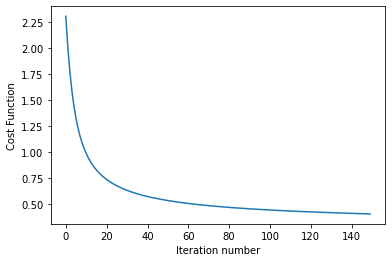

softmax test_error= 0.1005


In [18]:
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

Great! The linear softmax regression model is able to recognize MNIST digits with around 90 percent accuracy.

### Temperature

Smaller temperature parameter means that there is less variance in the distribution, which favors larger $\theta\$. While larger temperature makes the sample more uniformly distributed with more variance.

Test with different temperature parameters, and see how the cost function changes with the plots.

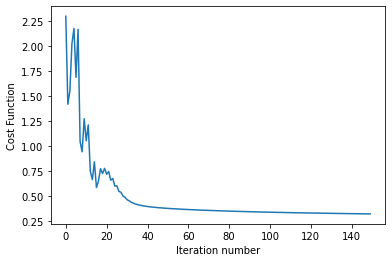

softmax test_error (r=0.5) = 0.084


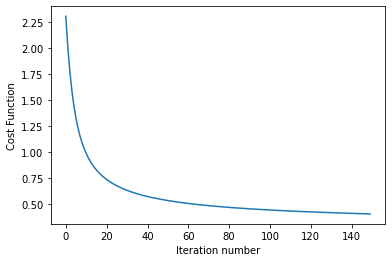

softmax test_error (r=1) = 0.1005


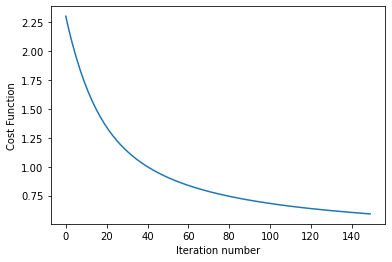

softmax test_error (r=2) = 0.1261


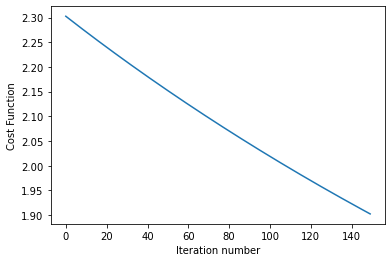

softmax test_error (r=10) = 0.2453


In [19]:
print('softmax test_error (r=0.5) =', run_softmax_on_MNIST(temp_parameter=0.5))
print('softmax test_error (r=1) =', run_softmax_on_MNIST(temp_parameter=1))
print('softmax test_error (r=2) =', run_softmax_on_MNIST(temp_parameter=2))
print('softmax test_error (r=10) =', run_softmax_on_MNIST(temp_parameter=10))

### Changing Labels

Another way to improve the algorithm is to classify the digits by their (mod 3) value, such that the new label $y^{i}$ of sample $i$ is the old $y^{i}$(mod3) . An example is provided in the next section.

### Using the Current Model - update target

Given that we already classified every $x^{i}$ as a digit, we could use the trained model, and just calculate the estimations (mod 3).

Implement `update_y` function, which changes the old digit labels for the training and test set for the new (mod 3) labels.

In [20]:
def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    train_y_mod3 = np.mod(train_y, 3)
    test_y_mod3 = np.mod(test_y, 3)
    
    return train_y_mod3, test_y_mod3

### Using the Current Model - compute test error

Implement `compute_test_error_mod3` function, which takes the test points $X$, their correct labels $Y$ (digits (mod 3) from 0-2), theta, and the temp_parameter, and returns the error.

For example:

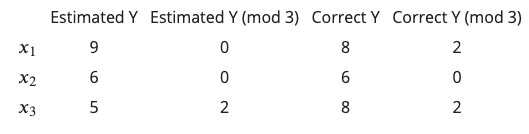
<!-- |   | Estimated Y | Estimated Y(mod3) | Correct Y| Correct Y(mod3) |
| :-: | :-: | :-: | :-: | :-: |
| $x_{1}$ | 9 | 0 | 8 | 2 |
| $x_{2}$ | 6 | 0 | 6 | 0 |
| $x_{3}$ | 5 | 2 | 8 | 2 | -->


The error of the regression with the original labels would be 0.66667.
In comparison, the error of the regression with the labels after the “mod 3" operation would be 0.33333.

In [21]:
def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    
    return 1 - np.mean(np.mod(assigned_labels, 3) == Y)

### Using the Current Model - test error

Find the error rate of the new labels (call these two functions at the end of `run_softmax_on_MNIST`).

In [22]:
def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)

    # Updated code
    train_y_mod3, test_y_mod3 = update_y(train_y, test_y)
    test_error = compute_test_error_mod3(test_x, test_y_mod3, theta, temp_parameter)
    
    return np.float32(test_error)

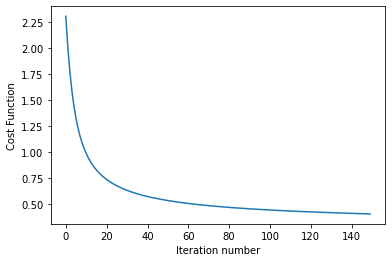

softmax test_error= 0.0768


In [23]:
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

### Retrain with New Labels

Rather than training the model to predict the original digits and then taking those predictions modulo 3, what if we explicitly train the model to predict the digits modulo 3 from the original image?

In [24]:
# Edit previous functions as Mod 3 version

def get_classification_mod3(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.mod(np.argmax(probabilities, axis = 0),3)

def run_softmax_on_MNIST_mod3(temp_parameter=1):
    """
    Trains Softmax regression on digit (mod 3) classifications.

    See run_softmax_on_MNIST for more info.
    """    
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y, test_y = update_y(train_y, test_y)
    
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, 
                                                      lambda_factor=1.0e-4, k=10, num_iterations=150)
    
    plot_cost_function_over_time(cost_function_history)
    
    test_error = compute_test_error_mod3(test_x, test_y, theta, temp_parameter)
    return np.float32(test_error)

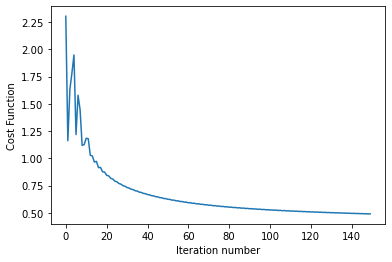

softmax test_error= 0.1872


In [25]:
print('softmax test_error=', run_softmax_on_MNIST_mod3())

With this approach and the new labels, the performance is decreased. We are looking for common features of all numbers that have the same mod 3 value, however a lot of them look widely different. Thus it is harder to separate the data set into 3 groups. For instance, 2 does not share many features with 5 or 8. Therefore one would expect the performance to decrease.

# Classification Using Manually Crafted Features

The performance of most learning algorithms depends heavily on the representation of the training data. In this section, we will try representing each image using different features in place of the raw pixel values. Subsequently, we will investigate how well our regression model from the previous section performs when fed different representations of the data.

In the following section, we will work with dimensionality reduction via PCA, and ubic feature mapping which maps an input vector into a new feature vector.

# 4. Dimensionality Reduction Using PCA

PCA finds (orthogonal) directions of maximal variation in the data. In this problem we're going to project our data onto the principal components and explore the effects on performance.

For the details, please visit (http://snobear.colorado.edu/Markw/BioMath/Otis/PCA/principal_components.ps).

### Project onto Principal Components

Write function `project_onto_PC` that implements PCA dimensionality reduction of dataset $X$.

Note that to project a given $n$ x $d$ dataset $X$ into its $k$-dimensional PCA representation, one can use matrix multiplication, after first centering $X$:

$\tilde{X}$$V$

where $\tilde{X}$ is the centered version of the original data $X$ using the mean learned from training data and $V$ is the $d$ x $k$ matrix whose columns are the top $k$ eigenvectors of $\tilde{X}$$T$$\tilde{X}$. This is because the eigenvectors are of unit-norm, so there is no need to divide by their length.

In [26]:
def center_data(X):
    """
    Returns a centered version of the data, where each feature now has mean = 0

    Args:
        X - n x d NumPy array of n data points, each with d features

    Returns:
        - (n, d) NumPy array X' where for each i = 1, ..., n and j = 1, ..., d:
        X'[i][j] = X[i][j] - means[j]       
    - (d, ) NumPy array with the columns means

    """
    feature_means = X.mean(axis=0)
    return (X - feature_means), feature_means


def principal_components(centered_data):
    """
    Returns the principal component vectors of the data, sorted in decreasing order
    of eigenvalue magnitude. This function first calculates the covariance matrix
    and then finds its eigenvectors.

    Args:
        centered_data - n x d NumPy array of n data points, each with d features

    Returns:
        d x d NumPy array whose columns are the principal component directions sorted
        in descending order by the amount of variation each direction (these are
        equivalent to the d eigenvectors of the covariance matrix sorted in descending
        order of eigenvalues, so the first column corresponds to the eigenvector with
        the largest eigenvalue
    """
    scatter_matrix = np.dot(centered_data.transpose(), centered_data)
    eigen_values, eigen_vectors = np.linalg.eig(scatter_matrix)
    
    # Re-order eigenvectors by eigenvalue magnitude
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    
    return eigen_vectors

In [27]:
def project_onto_PC(X, pcs, n_components, feature_means):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.
    """
    # TODO: first center data using the feature_means
    # TODO: Return the projection of the centered dataset
    #       on the first n_components principal components.
    #       This should be an array with dimensions: n x n_components.
    # Hint: these principal components = first n_components columns
    #       of the eigenvectors returned by principal_components().
    #       Note that each eigenvector is already be a unit-vector,
    #       so the projection may be done using matrix multiplication.
    
    X_centered = X - feature_means
    V = pcs[:,:n_components]
    X_proj = X_centered.dot(V)
    
    return X_proj

**Note:** we only use the training dataset to determine the principal components. It is improper to use the test dataset for anything except evaluating the accuracy of our predictive model. If the test data is used for other purposes such as selecting good features, it is possible to overfit the test set and obtain overconfident estimates of a model's performance.

### Testing PCA

Use `project_onto_PC` to compute a 18-dimensional PCA representation of the MNIST training and test datasets.

Retrain the softmax regression model (using the original labels) on the MNIST training dataset and report its error on the test data, this time using these 18-dimensional PCA-representations rather than the raw pixel values.

If the PCA implementation is correct, the model should perform nearly as well when only given 18 numbers encoding each image as compared to the 784 in the original data (error on the test set using PCA features should be around 0.15). This is because PCA ensures these 18 feature values capture the maximal amount of variation from the original 784-dimensional data.

In [28]:
def run_softmax_on_MNIST_PCA(temp_parameter=1, n_components=18):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    
    train_x_centered, feature_means = center_data(train_x)
    pcs = principal_components(train_x_centered)
    train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
    test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)

    theta, cost_function_history = softmax_regression(train_pca, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_pca, test_y, theta, temp_parameter)

    return np.float32(test_error)

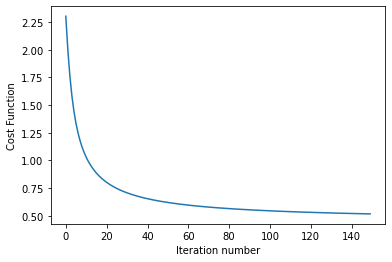

softmax test_error_PCA= 0.1474


In [29]:
print('softmax test_error_PCA=', run_softmax_on_MNIST_PCA())

Visualize the first 100 MNIST images, as represented in the space spanned by the first 2 principal components of the training data.

In [30]:
def plot_PC(X, pcs, labels, feature_means):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function projects each sample in X onto the first two principal components
    and produces a scatterplot where points are marked with the digit depicted in
    the corresponding image.
    labels = a numpy array containing the digits corresponding to each image in X.
    """
    pc_data = project_onto_PC(X, pcs, n_components=2, feature_means=feature_means)
    text_labels = [str(z) for z in labels.tolist()]
    fig, ax = plt.subplots()
    ax.scatter(pc_data[:, 0], pc_data[:, 1], alpha=0, marker=".")
    
    for i, txt in enumerate(text_labels):
        ax.annotate(txt, (pc_data[i, 0], pc_data[i, 1]))
        
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.show()

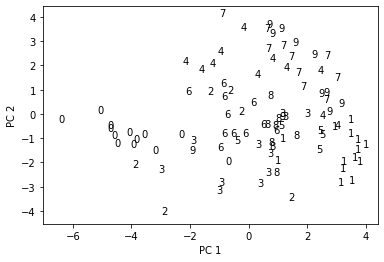

In [31]:
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)

plot_PC(train_x[range(000, 100), ], pcs, train_y[range(000, 100)], feature_means)

**Remark:** Two dimensional PCA plots offer a nice way to visualize some global structure in high-dimensional data, although approaches based on nonlinear dimension reduction may be more insightful in certain cases. Notice that for our data, the first 2 principal components are **insufficent** for fully separating the different classes of MNIST digits.

# 9. Cubic Features

In this section, we will work with a cubic feature mapping which maps an input vector $x=[x_{1},...,x_{n}]$ into a new feature vector $\phi(x)$ , defined so that for any $x$,$x'$∈$ℝ^{d}$:
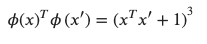

### Computing Cubic Features

In 2-D, let $x=[x_{1},x_{2}]$. Write down the explicit cubic feature mapping $\phi(x$)  as a vector; i.e.,

<!-- $\phi$($x$) $= [𝑓_{1}(𝑥_{1},𝑥_{2}),⋯,𝑓_{N}(𝑥_{1},𝑥_{2})]$ -->

So,
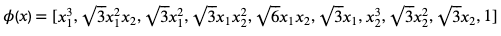
<!-- $\phi$($x$) $= [x_{1}^{3}, \sqrt{3}x_{1}^{2}x_{2}, \sqrt{3}x_{1}^{2}, \sqrt{3}x_{1}x_{2}^{2}, \sqrt{6}x_{1}x_{2}, \sqrt{3}x_{1},x_{2}^{3}, \sqrt{3}x_{2}^{2}, \sqrt{3}x_{2}, 1]$ -->

### Applying to MNIST

If we explicitly apply the cubic feature mapping to the original 784-dimensional raw pixel features, the resulting representation would be of massive dimensionality. Instead, we will apply the cubic feature mapping to the 10-dimensional PCA representation of our training data which we will have to calculate just as we calculated the 18-dimensional representation in the previous problem. 

After applying the cubic feature mapping to the PCA representations for both the train and test datasets, retrain the softmax regression model using these new features and report the resulting test set error below.

The `cubic_features` function can handle input with an arbitrary dimension, and compute the corresponding features for the cubic Kernel. Note that here we don't leverage the kernel properties that allow us to do a more efficient computation with the kernel function (without computing the features themselves). Instead, here we do compute the cubic features explicitly and apply the PCA on the output features.

In [32]:
def cubic_features(X):
    """
    Returns a new dataset with features given by the mapping
    which corresponds to the cubic kernel.
    """
    n, d = X.shape  # dataset size, input dimension
    X_withones = np.ones((n, d + 1))
    X_withones[:, :-1] = X
    new_d = 0  # dimension of output
    new_d = int((d + 1) * (d + 2) * (d + 3) / 6)

    new_data = np.zeros((n, new_d))
    col_index = 0
    for x_i in range(n):
        X_i = X[x_i]
        X_i = X_i.reshape(1, X_i.size)

        if d > 2:
            comb_2 = np.matmul(np.transpose(X_i), X_i)

            unique_2 = comb_2[np.triu_indices(d, 1)]
            unique_2 = unique_2.reshape(unique_2.size, 1)
            comb_3 = np.matmul(unique_2, X_i)
            keep_m = np.zeros(comb_3.shape)
            index = 0
            for i in range(d - 1):
                keep_m[index + np.arange(d - 1 - i), i] = 0

                tri_keep = np.triu_indices(d - 1 - i, 1)

                correct_0 = tri_keep[0] + index
                correct_1 = tri_keep[1] + i + 1

                keep_m[correct_0, correct_1] = 1
                index += d - 1 - i

            unique_3 = np.sqrt(6) * comb_3[np.nonzero(keep_m)]

            new_data[x_i, np.arange(unique_3.size)] = unique_3
            col_index = unique_3.size

    for i in range(n):
        newdata_colindex = col_index
        for j in range(d + 1):
            new_data[i, newdata_colindex] = X_withones[i, j]**3
            newdata_colindex += 1
            for k in range(j + 1, d + 1):
                new_data[i, newdata_colindex] = X_withones[i, j]**2 * X_withones[i, k] * (3**(0.5))
                newdata_colindex += 1

                new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k]**2 * (3**(0.5))
                newdata_colindex += 1

                if k < d:
                    new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k] * (6**(0.5))
                    newdata_colindex += 1

    return new_data

In [33]:
def run_softmax_on_MNIST_Cubic(temp_parameter=1, n_components=10):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    
    train_x_centered, feature_means = center_data(train_x)
    pcs = principal_components(train_x_centered)
    train_pca = cubic_features(project_onto_PC(train_x, pcs, n_components, feature_means)) # Added cubic feature
    test_pca = cubic_features(project_onto_PC(test_x, pcs, n_components, feature_means))

    alpha, cost_function_history = softmax_regression(train_pca, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_pca, test_y, alpha, temp_parameter)

    return np.float32(test_error)

<ipython-input-13-cc4684d48e37>:23: RuntimeWarning: divide by zero encountered in log
  H = np.log( compute_probabilities(X, theta, temp_parameter) )


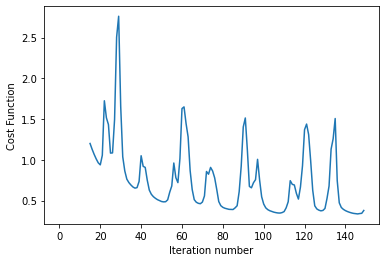

softmax test_error_Cubic= 0.084


In [34]:
print('softmax test_error_Cubic=', run_softmax_on_MNIST_Cubic(n_components=10))

# 10. Kernel Methods

As implementing a direct mapping to the high-dimensional features is a lot of work (imagine using an even higher dimensional feature mapping.) This is where the kernel trick becomes useful.

Based on the kernel perceptron algorithm, the weights $\theta$ can be represented by a linear combination of features:
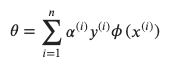

In the softmax regression fomulation, we can also apply this representation of the weights:
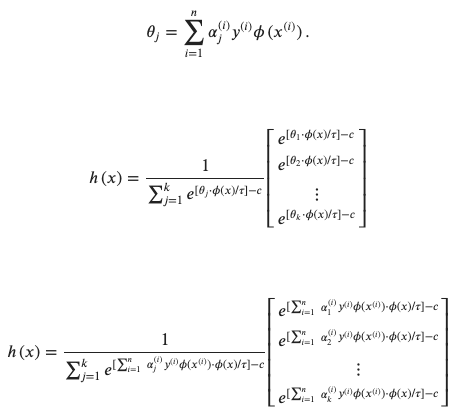


We actually do not need the real mapping $\phi(x)$, but the inner product between two features after mapping: $\phi(x_{i})⋅\phi(x)$, where $x_{i}$ is a point in the training set and $x$ is the new data point for which we want to compute the probability. If we can create a kernel function $K(x,y)=\phi(x)⋅\phi(y)$, for any two points $x$ and $y$, we can then kernelize our softmax regression algorithm.

### Implementing Polynomial Kernel

In the last section, we explicitly created a cubic feature mapping. Now, suppose we want to map the features into d dimensional polynomial space,

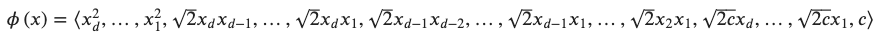

Write a function `polynomial_kernel` that takes in two matrix $X$ and $Y$ and computes the polynomial kernel $K(x,y)$ for every pair of rows $x$ in $X$ and $y$ in $Y$.

In [35]:
def polynomial_kernel(X, Y, c, p):
    """
        Compute the polynomial kernel between two matrices X and Y::
            K(x, y) = (<x, y> + c)^p
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            c - a coefficient to trade off high-order and low-order terms (scalar)
            p - the degree of the polynomial kernel

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    kernel_matrix = (np.dot(X, Y.T) + c)**p
    return kernel_matrix

### Gaussian RBF Kernel

Another commonly used kernel is the Gaussian RBF kenel. Similarly, write a function `rbf_kernel` that takes in two matrices $X$ and $Y$, and computes the RBF kernel $K(x,y)$ for every pair of rows $x$ in $X$ and $y$ in $Y$.

In [36]:
def rbf_kernel(X, Y, gamma):
    """
        Compute the Gaussian RBF kernel between two matrices X and Y::
            K(x, y) = exp(-gamma ||x-y||^2)
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            gamma - the gamma parameter of gaussian function (scalar)

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    n, d = X.shape
    m = Y.shape[0]
    
    kernel_matrix = np.dot(X**2, np.ones((d,m))) + np.dot(np.ones((n,d)), (Y.T)**2) - (2 * np.dot(X, Y.T))
    kernel_matrix = np.exp(-gamma*kernel_matrix)
    
    return kernel_matrix

Then, adjust the required functions for kernelized softmax regression.

In [37]:
def compute_probabilities_kernel(kernel_matrix, alpha_matrix, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        kernel_matrix - (n, d) NumPy array (phi of n datapoints each with d features)
        alpha_matrix - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    aux = np.dot(alpha_matrix, kernel_matrix) / temp_parameter
    c = np.max(aux, axis=0)
    aux = aux - c
    
    numerator = np.exp(aux)
    denumerator = np.sum(numerator, axis=0)
    H = numerator / denumerator
    
    return H

In [38]:
def compute_cost_function_kernel(kernel_matrix, alpha_matrix, Y, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        kernel_matrix - (n, d) NumPy array (phi of n datapoints each with d features)
        alpha_matrix - (k, d) NumPy array, where row j represents the parameters of our model for label j
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    k = alpha_matrix.shape[0]
    n = kernel_matrix.shape[0]
    
    # Loss term
    H = np.log( np.clip(compute_probabilities_kernel(kernel_matrix, alpha_matrix, temp_parameter), 1e-15, 1-1e-15))
    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape = (k,n)).toarray()
    loss_term = (-1/n) * np.sum(H[M == 1])
                
    # Regularization term
    reg_term = (lambda_factor/2) * (np.linalg.norm(alpha_matrix)**2)
    
    return loss_term + reg_term

In [39]:
def compute_gradient_kernel(kernel_matrix, alpha_matrix, Y, lambda_factor, temp_parameter):
    """
    Computes the gradient of the cost function.

    Args:
        kernel_matrix - (n, d) NumPy array (phi of n datapoints each with d features)
        alpha_matrix - (k, d) NumPy array, where row j represents the parameters of our model for label j
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        grad_matrix - the gradient matrix of the alpha matrix
    """
    k = alpha_matrix.shape[0]
    n = kernel_matrix.shape[0]
    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape = (k,n)).toarray()
    
    # Probability and gradient matrix
    P = compute_probabilities_kernel(kernel_matrix, alpha_matrix, temp_parameter)
    grad_matrix = (-1/(temp_parameter*n)) * ((M - P).dot(kernel_matrix)) + (lambda_factor * alpha_matrix)
    
    return grad_matrix

In [40]:
def run_gradient_descent_iteration_kernel(kernel_matrix, alpha_matrix, Y, learning_rate, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        kernel_matrix - (n, d) NumPy array (phi of n datapoints each with d features)
        alpha_matrix - (k, d) NumPy array, where row j represents the parameters of our model for label j
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        learning_rate - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        alpha_matrix - (k, d) NumPy array that is the final value of parameter alpha
    """
    grad_alpha = compute_gradient_kernel(kernel_matrix, alpha_matrix, Y, lambda_factor, temp_parameter)
    alpha_matrix = alpha_matrix - (learning_rate * grad_alpha)
    
    return alpha_matrix

In [41]:
def softmax_regression_kernel(kernel_matrix, Y, temp_parameter, learning_rate, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        kernel_matrix - (n, d) NumPy array (phi of n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        learning_rate - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        alpha - (k, d) NumPy array that is the final value of alpha
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    alpha = np.zeros([k, len(Y)])
    cost_function_progression = []
    
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function_kernel(kernel_matrix, alpha, Y, lambda_factor, temp_parameter))
        alpha = run_gradient_descent_iteration_kernel(kernel_matrix, alpha, Y, learning_rate, lambda_factor, temp_parameter)
        
    return alpha, cost_function_progression

### Test Error on Softmax Regression
Finally, calculate the final test error with the softmax regression using kernelized features.

In [42]:
def get_classification_kernel(kernel_matrix, alpha_matrix, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        kernel_matrix - (n, d) NumPy array (phi of n datapoints each with d features)
        alpha_matrix - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    probabilities = compute_probabilities_kernel(kernel_matrix, alpha_matrix, temp_parameter)
    return np.argmax(probabilities, axis = 0)
    
def compute_test_error_kernel(kernel_matrix, alpha_matrix, Y, temp_parameter):
    assigned_labels = get_classification_kernel(kernel_matrix, alpha_matrix, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)

In [43]:
def run_softmax_on_MNIST_kernel(temp_parameter=1, n_components=18):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Returns:
        Final test error
    """
    
    train_x, train_y, test_x, test_y = get_MNIST_data()
    
    # K(x,y) is too big for 60,000 x 60,000 MNIST dataset
    train_idx = np.random.permutation(6000)
    test_idx = np.random.permutation(1000)

    train_x_p = train_x[train_idx,:]
    train_y_p = train_y[train_idx]
    test_x_p = test_x[test_idx,:]
    test_y_p = test_y[test_idx]
    
    # PCA
    train_x_centered, feature_means = center_data(train_x_p)
    pcs = principal_components(train_x_centered)
    pcs = principal_components(train_x_p)
    train_pca = project_onto_PC(train_x_p, pcs, n_components, feature_means)
    test_pca = project_onto_PC(test_x_p, pcs, n_components, feature_means)
    
    # Kernel matrix for training and testing data
    train_kernel = rbf_kernel(train_pca, train_pca, gamma=0.5)
    test_kernel = rbf_kernel(train_pca, test_pca, gamma=0.5)
    
    alpha, cost_function_history = softmax_regression_kernel(train_kernel, train_y_p, temp_parameter=1, \
                                                             learning_rate=0.6, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error_kernel(test_kernel, alpha, test_y_p, temp_parameter)

    return np.float32(test_error)

/Users/BillyLam/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


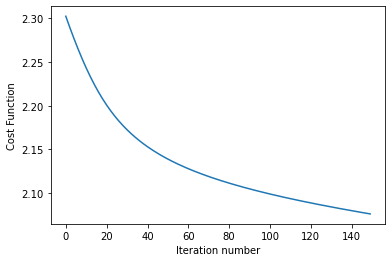

softmax test_error_Kernel= 0.089


In [44]:
print('softmax test_error_Kernel=', run_softmax_on_MNIST_kernel(n_components=18))

In this project, we explored different algorithms for the MNIST dataset for digit recognition, a popular task in computer vision.

We started with scikit-learn's SVM for binary classification and multiclass classification. Then, we implemented softmax regression using gradient descent. Finally, we also experimented with different hyperparameters, different labels and different features, including kernelized features.

This is the first part for solving this problem. Coming up next, we will solve the same task with neural networks and see if the performance can be improved.

# Thank you!